In [10]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from collections import Counter

In [11]:
pickle_file = 'douban.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (100000, 735) (100000,)
Validation set (5000, 735) (5000,)
Test set (5000, 735) (5000,)


<BarContainer object of 5 artists>

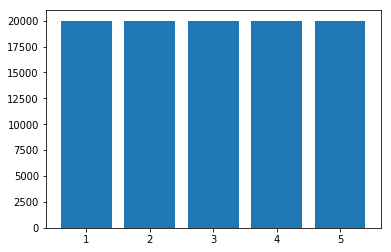

In [12]:
plt.bar(Counter(train_labels).keys(),Counter(train_labels).values())

<BarContainer object of 5 artists>

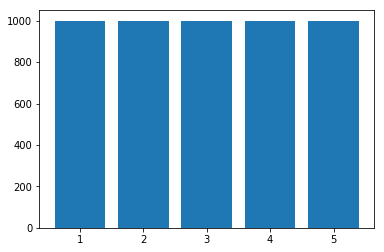

In [13]:
plt.bar(Counter(test_labels).keys(),Counter(test_labels).values())

<BarContainer object of 5 artists>

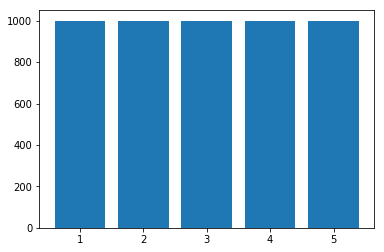

In [14]:
plt.bar(Counter(valid_labels).keys(),Counter(valid_labels).values())

In [16]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 24 10:52:39 2019

@author: comingboy
"""

num_labels = 5
num_lables = 5
word_size = 735


def reformat(dataset, labels):
  dataset = dataset.reshape((-1, word_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])


num_nodes = 128
batch_size = 512
graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, word_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_lables))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([word_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_lables]))
    biases_2 = tf.Variable(tf.zeros([num_lables]))

    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1) #add relu layer
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_2, labels = tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)

    # Predictions for validation
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2

    valid_prediction = tf.nn.softmax(logits_2)

    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2

    test_prediction =  tf.nn.softmax(logits_2)

num_steps = 5000
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Batch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))

Training set (100000, 735) (100000, 5)
Validation set (5000, 735) (5000, 5)
Test set (5000, 735) (5000, 5)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Initialized
Minibatch loss at step 0: 5.257460117340088
Batch accuracy: 18.6
Validation accuracy: 19.3
Minibatch loss at step 500: 2.999403953552246
Batch accuracy: 20.9
Validation accuracy: 17.8
Minibatch loss at step 1000: 2.5934743881225586
Batch accuracy: 22.5
Validation accuracy: 18.7
Minibatch loss at step 1500: 2.314324140548706
Batch accuracy: 20.7
Validation accuracy: 20.5
Minibatch loss at step 2000: 2.203524589538574
Batch accuracy: 21.1
Validation accuracy: 20.7
Minibatch loss at step 2500: 2.0458593368530273
Batch accuracy: 20.7
Validation accuracy: 21.2
Minibatch loss at step 3000: 2.3566811084747314
Batch accuracy: 18.0
Validation accuracy: 20.1
Minibatch loss at step 3500: 9.3553